# AI back test methods1

# --2 fonctions and dependancys


In [ ]:
#! python3 -m pip install --upgrade pip
#! pip install mplfinance
from xdata_config import *
from functions_module import *
import mplfinance as mpf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from datetime import datetime

In [ ]:
import requests

url = 'https://api.binance.com/api/v3/ticker/price'

response = requests.get(url)
tickers = response.json()
ticker_list=[]
for ticker in tickers:
    ticker_list.append((ticker['symbol']))


# --1 Config

In [ ]:
# ai_options
Normalization_File= "False"
Model_FileName= "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5"
WINDOW_SIZE= 7
PRESSISION=0.0
PERIODE_START="2022-04-21 00:00:00"
PERIODE_END="2022-05-11 00:00:00"

# start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
# end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')
start_period = pd.Timestamp(PERIODE_START)
end_period = pd.Timestamp(PERIODE_END)


#trading_options:
TAKE_PROFIT= 0.4  
STOP_LOSS=  0.8 
MAX_HOLDING_TIME= 16

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
  

In [ ]:
# Import necessary libraries
import pandas as pd
import mplfinance as mpf

# Import necessary libraries
import pandas as pd
import mplfinance as mpf

def plot_ohlcv(df,title, start_date, end_date):
    """
    Plots OHLCV data using mplfinance library.

    Args:
    df (pd.DataFrame): Dataframe containing OHLCV data with columns ['date', 'open', 'high', 'low', 'close', 'volume'].
    start_date (str): Start date of the plot in the format 'YYYY-MM-DD'.
    end_date (str): End date of the plot in the format 'YYYY-MM-DD'.
    """

    # # Ensure the index is of type datetime and sorted
    # df['date'] = pd.to_datetime(df['date'])
    # df = df.set_index('date')
    # df = df.sort_index()

    # Filter the data between start_date and end_date
    mask = (df.index >= start_date) & (df.index <= end_date)
    filtered_df = df.loc[mask]

    # Set the plot size to full width
    fig_width = 25
    fig_height = 9

    # Plot the OHLCV chart
    mpf.plot(filtered_df, type='candle', style='charles', volume=True, title=title, ylabel='Price', ylabel_lower='Volume', figratio=(fig_width, fig_height),  tight_layout=True)


best_testing_pair="LTC/USDT"
plot_ohlcv(df_list1h[best_testing_pair],best_testing_pair, start_date=PERIODE_START, end_date=PERIODE_END)


In [ ]:
def find_worst_period(df, window):
    """
    Find the worst period with the largest price drop in the given OHLCV DataFrame.

    Args:
    df (pd.DataFrame): Dataframe containing OHLCV data with columns ['date', 'open', 'high', 'low', 'close', 'volume'].
    window (int): Window size for calculating the largest price drop.

    Returns:
    (pd.Timestamp, pd.Timestamp): Start and end date of the worst period.
    """


    # Calculate rolling minimum close prices
    min_close = df['close'].rolling(window=window).min()

    # Find the largest price drop within the specified window
    largest_drop = (df['close'] / min_close.shift(1) - 1).idxmin()

    # Calculate start and end dates of the worst period
    start_date = largest_drop - pd.Timedelta(days=window-1)
    end_date = largest_drop

    return start_date, end_date

WORST_BTC_PERIOD=find_worst_period(df_list1h[best_testing_pair], window=10)
plot_ohlcv(df_list1h[best_testing_pair],best_testing_pair, start_date=WORST_BTC_PERIOD[0], end_date=WORST_BTC_PERIOD[1])


# --3 Importing DATA

In [ ]:
from datetime import date
#TICKERS = "../Binance-Fast-Trade-Bot/volatile_volume_" + str(date.today()) + ".txt"
TICKERS = "/UltimeTradingBot/Binance-Fast-Trade-Bot/halal_coins.txt"
VOLATILE_COINS=[line.strip() for line in open(TICKERS)]
PAIR_WITH="USDT"
VOLATILE_USDT_PAIRS=[coin+"/USDT" for coin in VOLATILE_COINS]
VOLATILE_BUSD_PAIRS=[coin+"/BUSD" for coin in VOLATILE_COINS]
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/' ,'') not  in ticker_list:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '') not in ticker_list:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)

content = os.listdir('database/DataBackTest/1m')
for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

In [ ]:
# coins_to_download=''
# for coin in LISTCOIN:
#     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/dd_for_backtest.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [ ]:
pair_list = VOLATILE_USDT_PAIRS
#tf = '1m'
oldest_pair = "BTC/USDT"
if oldest_pair not in pair_list: pair_list.append(oldest_pair)
df_list1m = {}
df_list1d = {}
df_list1h = {}
df_list5m = {}
df_list15m = {}


for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1m', path="./database/")
    df_list1m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1d', path="./database/")
    df_list1d[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1h', path="./database/")
    df_list1h[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '5m', path="./database/")
    df_list5m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(
        ccxt.binance(), pair, '15m', path="./database/")
    df_list15m[pair] = df.loc[:]
del(df)
df_list = df_list1m
prerr("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



# --3 Decalring Tables

### Functions

In [ ]:
import pandas as pd

def mini_expand5(pair="GMT/USDT", i=0, j=10000, window=2, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase):
    start_index=i
    end_index=j
    window_size=window
    buy_fn=buy_function
    """
    This function takes in several parameters to calculate technical indicators and returns a merged dataframe.
    
    :param pair: str, default "GMT/USDT"
        The trading pair to analyze.
        
    :param start_index: int, default 0
        The start index for selecting data.
        
    :param end_index: int, default 10000
        The end index for selecting data.
    
    :param window_size: int, default 2
        The window size to use for analyzing the data.
    
    :param metadata: MetaData
        The metadata to use for analyzing the data.
    
    :param high_weight: int, default 1
        The weight to use for calculating the high.
    
    :param BUY_PCT: float, default BUY_PCT
        The buy pct to use for analyzing the data.
    
    :param SELL_PCT: float, default SELL_PCT
        The sell pct to use for analyzing the data.
    
    :param buy_fn: function, default buy_min_up
        The buy function to use for analyzing the data.
    
    :return: pd.DataFrame
        A merged dataframe containing the calculated technical indicators.
    """
    pdebug(f"mini_expand : {pair}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair], window_size)
    btc_full = full_expand(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], window_size)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=MAX_FORCAST_SIZE)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"])
    open_high_low_close_cols = merged.columns.str.contains("open|high|low|close")
    # merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")] = (
    #     (merged["BTC_price"] - merged.loc[:, open_high_low_close_cols & merged.columns.str.contains("BTC")]) / merged["BTC_price"]
    # )
    # merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")] = (
    #     (merged["price"] - merged.loc[:, open_high_low_close_cols & ~merged.columns.str.contains("BTC")]) / merged["price"]
    # )
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["BTC_price"]-merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=(merged["price"]-merged[key])/merged["price"]

    merged=merged.dropna()
    pdebug(f'######################  mini_expand5 {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged


def create_portfolio_dataframe(num_slots,init_quantity=500, base_currency='usdt',PERIODE_START=PERIODE_START):
    # create an empty DataFrame with the columns we need
    columns = ['date', f'reserve_{base_currency}',f'total_{base_currency}']
    for i in range(num_slots):
        columns += [f'slot{i+1}_symbol', f'slot{i+1}_volume', f'slot{i+1}_original_price_{base_currency}', f'slot{i+1}_current_total_{base_currency}']
    df = pd.DataFrame(columns=columns)
    
    # create some sample data
    for date in pd.date_range(PERIODE_START, periods=1):
        data = {'date': date, f'total_{base_currency}': init_quantity}
        # for i in range(num_slots):
        #     symbol = f'coin{i+1}'
        #     volume = (i+1) * 100
        #     bought_currency = base_currency.upper()
        #     bought_value = (i+1) * 500
        #     current_price = (i+1) * 1.5
        #     current_total = volume * current_price
        #     data.update({
        #         f'slot{i+1}_symbol': symbol,
        #         f'slot{i+1}_volume': volume,
        #         f'slot{i+1}_original_price_{base_currency}': bought_value,
        #         f'slot{i+1}_current_total_{base_currency}': current_total,
        #     })
        #     data[f'total_{base_currency}'] += current_total
        df = df.append(data, ignore_index=True)
    
    # set the date column as the index of the DataFrame
    df.set_index('date', inplace=True)
    df.iloc[:,0]=np.float64(init_quantity)
    return df.iloc[0:1]



def generate_signals(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model):
    SIGNAL_DF = pd.DataFrame(columns=['coin', 'time', 'price', 'note'])
    for day, TOPLIST in ALLTOP20VOLUMES.items():
        for coin in TOPLIST:
            try:
                print(f">>>>>>>>>>> working on {coin} at: {day} :")
                loc_start = df_list1m[coin].index.get_loc(day)
                loc_end = df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
                gc.collect()
                df = mini_expand5(pair=coin, i=loc_start, j=loc_end, window=WINDOW_SIZE, metadata=MetaData, BUY_PCT=TAKE_PROFIT, SELL_PCT=STOP_LOSS, buy_function=buy_alwase)
                dt = df.iloc[:,:-1].to_numpy(dtype=np.float32)
                predictions_note = backtest_model.predict(dt)
                predictions_round = predictions_note.round()
                dico_signal = {"coin":coin, "time":df[predictions_round==1].index.values, "price":df[predictions_round==1]["price"].values, "note":predictions_note[predictions_round==1]}
                df_signal_coin = pd.DataFrame(dico_signal)
                SIGNAL_DF = pd.concat([SIGNAL_DF, df_signal_coin])
            except:
                print(f"error at {day} in {coin}")
    return SIGNAL_DF

import gc
import pandas as pd

def generate_signals_optimized(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model):
    SIGNAL_DF = pd.DataFrame(columns=['coin', 'time', 'price', 'note'])
    
    # Find all unique pairs in ALLTOP20VOLUMES
    unique_pairs = set(coin for top_list in ALLTOP20VOLUMES.values() for coin in top_list)

    # Find the min and max timestamp in ALLTOP20VOLUMES
    min_timestamp = min(ALLTOP20VOLUMES)
    max_timestamp = max(ALLTOP20VOLUMES)

    # Calculate mini_expand5 and generate signals for all unique pairs in the maximum time range
    for coin in unique_pairs:
        print(f">>>>>>>>>>> working on {coin} :")
        try:
            # Compare the min and max timestamp with the index of df_list1m
            start_date = max(min_timestamp, df_list1m[coin].index[0])
            end_date = min(max_timestamp, df_list1m[coin].index[-1])

            loc_start = df_list1m[coin].index.get_loc(start_date, method='nearest')
            loc_end = df_list1m[coin].index.get_loc(end_date, method='nearest')
            
            gc.collect()
            df = mini_expand5(pair=coin, i=loc_start, j=loc_end, window=WINDOW_SIZE, metadata=MetaData, BUY_PCT=TAKE_PROFIT, SELL_PCT=STOP_LOSS, buy_function=buy_alwase)
            
            dt = df.iloc[:, :-1].to_numpy(dtype=np.float32)
            
            # Preprocessing: Handle NaN and Inf values
            dt = np.nan_to_num(dt, nan=0.0)
            dt = np.clip(dt, -1e12, 1e12)
            predictions_note = backtest_model.predict(dt)
            predictions_round = predictions_note.round()
            
            for day in ALLTOP20VOLUMES:
                        start_of_day = day.replace(hour=0, minute=0)
                        end_of_day = day.replace(hour=23, minute=59)

                        for minute in pd.date_range(start_of_day, end_of_day, freq='1T'):
                            if minute in ALLTOP20VOLUMES and coin in ALLTOP20VOLUMES[minute]:
                                signal = predictions_round[df.index.get_loc(minute)]
                                note = predictions_note[df.index.get_loc(minute)]

                                if signal == 1:
                                    SIGNAL_DF = SIGNAL_DF.append({"coin": coin, "time": minute, "price": df.loc[minute, "price"], "note": note}, ignore_index=True)


        except Exception as e:
            print(f"Error while proceding {coin} : {e}")

    return SIGNAL_DF


def get_top_volumes(start_period,end_period):
    ALLTOP20VOLUMES={}
    for day in df_list1d["BTC/USDT"].index:
        if start_period<= day <= end_period:
            Top20vol={}
            for p,df in df_list1d.items():
                if p not in ["EUR/USDT","EUR/BUSD","BTC/USDT","BTC/BUSD"]:
                    try:Top20vol.update({p:(df.loc[day].volume*df.loc[day].close)})
                    except Exception as e :print(f'Time Error wile working on {p}: {e}')
                    #print (Top20vol)
            ALLTOP20VOLUMES.update({day:sorted(Top20vol, key=Top20vol.get, reverse=True)[:20]})
    return ALLTOP20VOLUMES

def is_coin_in_portfolio(symbol,instant,PORTFOLIO):
    for i in range(1,TRADE_SLOTS+1):
        try:
            if (PORTFOLIO[f"slot{i}_symbol"].loc[instant]==symbol):
                return i
        except Exception as e:
            print(f"error :{e}")
    return False

In [ ]:
PORTFOLIO=create_portfolio_dataframe(TRADE_SLOTS,init_quantity=500, base_currency=PAIR_WITH) #pair with plus slots plus total
ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
#SIGNAL_DF=pd.DataFrame(columns= ['coin', 'time',"price",'note'])
ALLTOP20VOLUMES=get_top_volumes(start_period,end_period)


In [ ]:
ALLTOP20VOLUMES[pd.Timestamp("2022-05-09")]

In [ ]:

backtest_model=load_model("/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_VeryDeep.h5")


In [ ]:
SIGNAL_DF = generate_signals(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model)

In [ ]:
# SIGNAL_DF[SIGNAL_DF.time=="2022-04-21 01:44:00"]

In [ ]:

# SIGNAL_DF=pd.DataFrame(columns= ['coin', 'time',"price",'note'])
# for day,TOPLIST in ALLTOP20VOLUMES.items():
#     for coin in TOPLIST:
#         try:
#             print(f">>>>>>>>>>> working on {coin} at: {day} :")
#             loc_start=df_list1m[coin].index.get_loc(day)
#             loc_end=df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
#             gc.collect()
#             df=mini_expand4(pair=coin,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=TAKE_PROFIT,SELL_PCT=STOP_LOSS,buy_function=buy_alwase)
#             dt=df.iloc[:,:-1].to_numpy(dtype=np.float32)
#             predictions_note=backtest_model.predict(dt)
#             predictions_round=predictions_note.round()
#             dico_signal={"coin":coin,"time":df[predictions_round==1].index.values,"price":df[predictions_round==1]["price"].values,"note":predictions_note[predictions_round==1]}
#             df_signal_coin = pd.DataFrame(dico_signal)
#             SIGNAL_DF=pd.concat([SIGNAL_DF,df_signal_coin])
#         except:
#             print(f"error at {day} in {coin}")

In [ ]:
# SIGNAL_DF = pd.DataFrame(columns=['coin', 'time', 'price', 'note'])

# for day, TOPLIST in ALLTOP20VOLUMES.items():
#     for coin in TOPLIST:
#         try:
#             print(f">>>>>>>>>>> working on {coin} at: {day} :")
#             loc_start = df_list1m[coin].index.get_loc(day)
#             loc_end = df_list1m[coin].index.get_loc(day + pd.Timedelta('1 day'))
#             gc.collect()

#             # Get the required columns from the dataframe
#             df = mini_expand5(pair=coin, i=loc_start, j=loc_end, window=WINDOW_SIZE, metadata=MetaData,
#                               BUY_PCT=TAKE_PROFIT, SELL_PCT=STOP_LOSS, buy_function=buy_alwase)
#             # Add the prediction note to the dataframe
#             df.pop("buy")
#             dt = df.to_numpy(dtype=np.float32)
#             predictions_note = backtest_model.predict(dt)
#             df["time"] = df.index.values
#             predictions_round = predictions_note.round()
#             df['note'] = predictions_note

#             # Filter the rows with positive predictions and create a dataframe with the signal
#             df_signal_coin = df[predictions_round == 1][['time', 'price', 'note']].reset_index(drop=True)
#             df_signal_coin['coin'] = coin

#             SIGNAL_DF = pd.concat([SIGNAL_DF, df_signal_coin])
#         except:
#             print(f"error at {day} in {coin}")

In [ ]:
# coin="XRP/USDT"
# day=pd.Timestamp("2023-02-10 00:00:00")
# loc_start=df_list1m[coin].index.get_loc(day)
# loc_end=df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
# gc.collect()
# df=mini_expand4(pair=coin,i=loc_start,j=loc_end,window=WINDOW_SIZE,metadata=MetaData,BUY_PCT=TAKE_PROFIT,SELL_PCT=STOP_LOSS,buy_function=buy_alwase)
# df.pop("buy")
# dt = df.to_numpy(dtype=np.float32)
# predictions_note = backtest_model.predict(dt)
# df["time"] = df.index.values
# predictions_round = predictions_note.round()
# df['note'] = predictions_note

# # Filter the rows with positive predictions and create a dataframe with the signal
# df_signal_coin = df[predictions_round == 1][['time', 'price', 'note']].reset_index(drop=True)
# df_signal_coin['coin'] = coin

# SIGNAL_DF = pd.concat([SIGNAL_DF, df_signal_coin])
# # dt=df.iloc[:,:-1].to_numpy(dtype=np.float32)
# # predictions_note=backtest_model.predict(dt)
# # predictions_round=predictions_note.round()
# # dico_signal={"coin":coin,"time":df[predictions_round==1].index.values,"price":df[predictions_round==1]["price"].values,"note":predictions_note[predictions_round==1]}
# # df_signal_coin = pd.DataFrame(dico_signal)
# #SIGNAL_DF=pd.concat([SIGNAL_DF,df_signal_coin])

In [ ]:

# def backtest_buy_sell(PORTFOLIO, ORDER_HISTORY, SIGNAL_DF, df_list1m, start_period, end_period):
#     # Define some constants
#     BUY_SIDE = 'BUY'
#     SELL_SIDE = 'SELL'
#     EXECUTED_STATUS = 'EXECUTED'
#     CANCELLED_STATUS = 'CANCELLED'

#     # Loop through all the rows in the signal dataframe
#     for index, row in SIGNAL_DF.iterrows():
#         coin = row['coin']
#         time = row['time']
#         price = row['price'] # We assume there's only one price per signal
#         note = row['note'] # We assume there's only one note per signal

#         # Check if the coin is already in the PORTFOLIO
#         slot_num = is_coin_in_portfolio(coin, time)
#         if slot_num:
#             # If the coin is already in the PORTFOLIO, update the existing slot
#             slot_symbol = f'slot{slot_num}_symbol'
#             slot_volume = f'slot{slot_num}_volume'
#             slot_original_price_usdt = f'slot{slot_num}_original_price_USDT'
#             slot_current_total_usdt = f'slot{slot_num}_current_total_USDT'

#             # Calculate the new volume and bought USDT based on the current price
#             current_total_usdt = PORTFOLIO['total_USDT'].iloc[-1]
#             new_volume = (PORTFOLIO[slot_original_price_usdt].iloc[-1] * (1 - TRADING_FEE)) / price
#             new_original_price_usdt = new_volume * price

#             # Update the PORTFOLIO dataframe
#             PORTFOLIO.at[time, slot_volume] = new_volume
#             PORTFOLIO.at[time, slot_original_price_usdt] = new_original_price_usdt
#             PORTFOLIO.at[time, slot_current_total_usdt] = new_original_price_usdt + (current_total_usdt - PORTFOLIO[slot_original_price_usdt].iloc[-1])

#             # Add an order to the order history dataframe
#             order_id = len(ORDER_HISTORY) + 1
#             order_side = SELL_SIDE if note < 0 else BUY_SIDE
#             order_executed = abs(note)
#             order_quantity = new_volume
#             order_status = EXECUTED_STATUS
#             order_price = price
#             order_time = time
#             order_pair = f'{coin}/{PAIR_WITH}'

#             ORDER_HISTORY = ORDER_HISTORY.append({'Order ID': order_id, 'Pair': order_pair, 'Side': order_side,
#                                                   'Price': order_price, 'Quantity': order_quantity,
#                                                   'Executed': order_executed, 'Time': order_time,
#                                                   'Status': order_status}, ignore_index=True)
#         else:
#             # If the coin is not in the PORTFOLIO, find the first empty slot
#             for i in range(1, TRADE_SLOTS + 1):
#                 if pd.isna(PORTFOLIO[f'slot{i}_symbol'].iloc[-1]):
#                     # Calculate the volume and bought USDT based on the current price
#                     volume = (MAX_TRADE_PER_SLOTE * (1 - TRADING_FEE)) / price
#                     bought_usdt = volume * price

#                     # Update the PORTFOLIO dataframe
#                     PORTFOLIO.at[time, f'slot{i}_symbol'] = coin
#                     PORTFOLIO.at[time, f'slot{i}_volume'] = volume
#                     PORTFOLIO.at[time, f'slot{i}_original_price_USDT'] = bought_usdt
#                     PORTFOLIO.at[time, f'slot{i}_current_total_USDT'] = bought_usdt + PORTFOLIO['total_USDT'].iloc[-1]
#                 # Add an order to the order history dataframe
#                 order_id = len(ORDER_HISTORY) + 1
#                 order_side = BUY_SIDE
#                 order_executed = abs(note)
#                 order_quantity = volume
#                 order_status = EXECUTED_STATUS
#                 order_price = price
#                 order_time = time
#                 order_pair = f'{coin}/{PAIR_WITH}'

#                 ORDER_HISTORY = ORDER_HISTORY.append({'Order ID': order_id, 'Pair': order_pair, 'Side': order_side,
#                                                         'Price': order_price, 'Quantity': order_quantity,
#                                                         'Executed': order_executed, 'Time': order_time,
#                                                         'Status': order_status}, ignore_index=True)

#                 break

#     return PORTFOLIO, ORDER_HISTORY
                    


In [ ]:
PORTFOLIO.columns

The code is a backtesting strategy to simulate buying and selling cryptocurrencies using a given signal DataFrame and historical prices of the cryptocurrencies.

The PORTFOLIO DataFrame is used to keep track of the state of the PORTFOLIO at each point in time during the backtesting. It contains information about the reserved and total amounts of the base currency (USDT), as well as the symbols, volumes, original prices, and current total values of up to 5 cryptocurrencies held in slots.

The fisrt_empty_slot() function checks if there is an empty slot in the PORTFOLIO where a new cryptocurrency can be added. If there is an empty slot, it returns the slot number. Otherwise, it returns False.

The buy_coin() function simulates buying a cryptocurrency at a given time and price. It checks if the cryptocurrency is not already in the PORTFOLIO and if there is enough reserved base currency to buy it. If the conditions are met, it updates the PORTFOLIO DataFrame by subtracting the base currency used for buying and adding the bought cryptocurrency to an empty slot. It also prints a message indicating the amount and symbol of the bought cryptocurrency. Otherwise, it prints a message indicating that the buying cannot be performed.

The upadate_slots() function updates the PORTFOLIO DataFrame for the current time by computing the current values of all the cryptocurrencies held in the slots using the historical prices of the cryptocurrencies. It then updates the slot information in the PORTFOLIO DataFrame.

The stop_loss_or_take_profit() function is not implemented in the provided code.

The backtest_buy_sell() function is the main function that performs the backtesting. It initializes the PORTFOLIO and ORDER_HISTORY DataFrames, defines some constants, and loops over the time range specified by the start_period and end_period parameters. At each time step, it checks the signal DataFrame for a buying or selling signal, and if there is a buying signal, it calls the buy_coin() function. If there is a selling signal, it calls the stop_loss_or_take_profit() function (not implemented) to check if the stop-loss or take-profit conditions are met, and if they are, it simulates selling the cryptocurrency by calling the sell_coin() function (not implemented). It then updates the PORTFOLIO and ORDER_HISTORY DataFrames for the current time step by calling the upadate_slots() function. Finally, it checks if the maximum holding time for each slot has been exceeded, and if it has, it simulates selling the cryptocurrency in that slot by calling the sell_coin() function (not implemented). The function returns the PORTFOLIO and ORDER_HISTORY DataFrames at the end of the backtesting.

In [255]:
PDEBUG=False
def pdebug(err):
    if PDEBUG:
        print("\033[0;31m Debug msg: "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

def first_empty_slot(time, PORTFOLIO):
    for i in range(1, TRADE_SLOTS + 1):
        if pd.isna(PORTFOLIO.at[time, f'slot{i}_symbol']):
            return i
    return False

def buy_coin(time, coin, price, PORTFOLIO, pair_with_qte=TRADE_TOTAL):
    # pdebug("buy coin")
    slot_num = is_coin_in_portfolio(coin, time, PORTFOLIO)
    current_reserve = PORTFOLIO.at[time, f'reserve_{PAIR_WITH}']
    slot_ft = first_empty_slot(time, PORTFOLIO)
    
    if (not slot_num) and (current_reserve >= pair_with_qte):
        PORTFOLIO.at[time, f'reserve_{PAIR_WITH}'] = current_reserve - pair_with_qte
        PORTFOLIO.at[time, f'total_{PAIR_WITH}'] = PORTFOLIO.at[time, f'total_{PAIR_WITH}'] - TRADING_FEE * pair_with_qte / 100
        PORTFOLIO.at[time, f'slot{slot_ft}_symbol'] = coin
        PORTFOLIO.at[time, f'slot{slot_ft}_volume'] = (pair_with_qte - (TRADING_FEE * pair_with_qte / 100)) / price
        PORTFOLIO.at[time, f'slot{slot_ft}_original_price_{PAIR_WITH}'] = price
        PORTFOLIO.at[time, f'slot{slot_ft}_current_total_{PAIR_WITH}'] = price * PORTFOLIO.at[time, f'slot{slot_ft}_volume']
        pdebug(f"Good condition for buying {PORTFOLIO.at[time, f'slot{slot_ft}_volume']} x {coin} at {price}")
        # pdebug(PORTFOLIO.tail)
    else:
        pdebug(f"xxx We cannot buy {coin} at {price} in {time} xxx")
    return PORTFOLIO

def update_slots(time, df_list1m, PORTFOLIO):
    # pdebug("update_slots")
    if time - pd.Timedelta("1 minute") in PORTFOLIO.index:
        previous_minute = time - pd.Timedelta("1 minute")
    else:
        return PORTFOLIO  # Exit the function if previous_minute is not in the DataFrame index

    previous_reserve = PORTFOLIO.at[previous_minute, f'reserve_{PAIR_WITH}']
    previous_total = PORTFOLIO.at[previous_minute, f'total_{PAIR_WITH}']

    PORTFOLIO.at[time, f'reserve_{PAIR_WITH}'] = previous_reserve
    PORTFOLIO.at[time, f'total_{PAIR_WITH}'] = previous_total

    for slot_ft in range(1, TRADE_SLOTS + 1):
        if not pd.isna(PORTFOLIO.at[previous_minute, f'slot{slot_ft}_symbol']):
            # Get previous data
            previousslot=PORTFOLIO.at[previous_minute, f'slot{slot_ft}_symbol']
            # print(f"update_slots ->  previous slot {previousslot}")
            coin = PORTFOLIO.at[previous_minute, f'slot{slot_ft}_symbol']
            bought_at = PORTFOLIO.at[previous_minute, f'slot{slot_ft}_original_price_{PAIR_WITH}']
            previous_total_slot_value = PORTFOLIO.at[previous_minute, f'slot{slot_ft}_current_total_{PAIR_WITH}']
            slot_volume = PORTFOLIO.at[previous_minute, f'slot{slot_ft}_volume']
            # Computation 
            new_total_slot_value = df_list1m[coin].at[time, "close"] * slot_volume
            slot_value_difference = new_total_slot_value - previous_total_slot_value
            new_total_assets_value = previous_total + slot_value_difference
            pdebug(f"update_slots -> new_total_assets_value : {new_total_assets_value}")
            # Update the slot using the new price from df_list1m dataset
            PORTFOLIO.at[time, f'slot{slot_ft}_symbol'] = coin
            PORTFOLIO.at[time, f'slot{slot_ft}_original_price_{PAIR_WITH}'] = bought_at
            PORTFOLIO.at[time, f'slot{slot_ft}_volume'] = slot_volume
            PORTFOLIO.at[time, f'slot{slot_ft}_current_total_{PAIR_WITH}'] = new_total_slot_value
            PORTFOLIO.at[time, f'total_{PAIR_WITH}'] = new_total_assets_value  
        else:
            # print(f"no coin in slot {slot_ft}")
            pass         
    return PORTFOLIO

def stop_loss_or_take_profit(time, df_list1m, PORTFOLIO, st_pct, tp_pct, trade_fee_ptc):
    pdebug(f"stop_loss at {st_pct }% or take_profit at {tp_pct}% with trade_fee_ptc at {trade_fee_ptc}%")
    for slot_ft in range(1, TRADE_SLOTS+1):
        if pd.isna(PORTFOLIO.at[time, f"slot{slot_ft}_symbol"]):
            pdebug(f"no coin in slot {slot_ft}")
            continue
        coin = PORTFOLIO.at[time, f"slot{slot_ft}_symbol"]
        # Check if stop loss or take profit order should be triggered
        bought_price = PORTFOLIO.at[time, f"slot{slot_ft}_original_price_{PAIR_WITH}"]
        slot_volume = PORTFOLIO.at[time, f"slot{slot_ft}_volume"]
        current_price = df_list1m[coin].at[time, "close"]
        slot_total_value = PORTFOLIO.at[time, f'slot{slot_ft}_current_total_{PAIR_WITH}']  #current_price * slot_volume
        slot_fee=(trade_fee_ptc/100 * slot_total_value)
        slot_current_profit = ((current_price - bought_price) * slot_volume)# - slot_fee
        slot_current_profit_pct = (slot_current_profit / (bought_price * slot_volume)) * 100
        if slot_current_profit_pct < -st_pct:
            # Trigger stop loss
            pdebug(f"coin: {coin} in slot {slot_ft}")

            PORTFOLIO.at[time, f"slot{slot_ft}_symbol"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_volume"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_original_price_{PAIR_WITH}"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_current_total_{PAIR_WITH}"] = np.nan
            PORTFOLIO.at[time, f"total_{PAIR_WITH}"] -=   slot_fee
            PORTFOLIO.at[time, f"reserve_{PAIR_WITH}"] += (slot_total_value - slot_fee)
            pdebug(f"Stop loss triggered for {coin} in slot {slot_ft}")

        elif slot_current_profit_pct > tp_pct:
            # Trigger take profit
            PORTFOLIO.at[time, f"slot{slot_ft}_symbol"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_volume"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_original_price_{PAIR_WITH}"] = np.nan
            PORTFOLIO.at[time, f"slot{slot_ft}_current_total_{PAIR_WITH}"] = np.nan
            PORTFOLIO.at[time, f"total_{PAIR_WITH}"] -=   slot_fee
            PORTFOLIO.at[time, f"reserve_{PAIR_WITH}"] += (slot_total_value - slot_fee)
            pdebug(f"Take profit triggered for {coin} in slot {slot_ft}")

    return PORTFOLIO







In [267]:

def backtest_buy_sell(SIGNAL_DF, df_list1m, start_period, end_period):
    pdebug(f"---   Backtesting form {start_period} to {end_period} while tp:{TAKE_PROFIT}% and sl:{STOP_LOSS}% and trading fee: {TRADING_FEE}% --- ")
    # Initialize variables and counters
    current_time = pd.Timestamp(start_period)
    end_period_margin = end_period + pd.Timedelta(f"{2 * MAX_HOLDING_TIME} minute")
    PORTFOLIO = create_portfolio_dataframe(TRADE_SLOTS, init_quantity=550, base_currency=PAIR_WITH, PERIODE_START=start_period)
    PeriodRange = pd.date_range(start=pd.Timestamp(start_period), end=pd.Timestamp(end_period), freq='1min')

    # Verify buying opportunities
    for current_time in PeriodRange:
        if current_time == pd.Timestamp(start_period):
            pdebug(f"update_slots -> The first case : {current_time}")
            PORTFOLIO.loc[current_time + pd.Timedelta("1 minute")] =PORTFOLIO.loc[current_time]
            continue
        else:
            previous_minute = current_time - pd.Timedelta("1 minute")
        # print(PORTFOLIO.tail)
        PORTFOLIO=update_slots(current_time, df_list1m, PORTFOLIO=PORTFOLIO)
        pdebug(current_time)

        for i, sig_row in SIGNAL_DF[SIGNAL_DF.time == pd.Timestamp(current_time)].iterrows():
            # Buy the coin if slot and cash is available:
            coin = sig_row['coin']
            time = sig_row['time']
            price = sig_row['price']  # We assume there's only one price per signal
            note = sig_row['note']
            slot_num = is_coin_in_portfolio(coin, previous_minute, PORTFOLIO)

            # Buy first:
            if (note + PRECISION) >= 0.5:
                PORTFOLIO = buy_coin(time, coin, price, PORTFOLIO=PORTFOLIO, pair_with_qte=TRADE_TOTAL)

        PORTFOLIO = stop_loss_or_take_profit(current_time, df_list1m, PORTFOLIO, STOP_LOSS, TAKE_PROFIT, TRADING_FEE)

        pct_benefit = 100 * PORTFOLIO.at[current_time, f'total_{PAIR_WITH}'] / PORTFOLIO[f'total_{PAIR_WITH}'].iloc[0]
        pdebug(f"Total benefit pct {pct_benefit}")
        
    return PORTFOLIO




import matplotlib.pyplot as plt

def back_test_metrics_v1(PORTFOLIO):
    initial_investment = PORTFOLIO.at[PORTFOLIO.index[0], f"reserve_{PAIR_WITH}"]
    final_value = PORTFOLIO.at[PORTFOLIO.index[-1], f"total_{PAIR_WITH}"]
    profit = final_value - initial_investment
    roi = (profit / initial_investment) * 100

    print(f"Initial Investment: {initial_investment:.2f} {PAIR_WITH}")
    print(f"Final Value: {final_value:.2f} {PAIR_WITH}")
    print(f"Profit: {profit:.2f} {PAIR_WITH}")
    print(f"Return on Investment (ROI): {roi:.2f}%")

    # Draw plot of total assets
    plt.plot(PORTFOLIO.index, PORTFOLIO[f"total_{PAIR_WITH}"])
    plt.xlabel("Time")
    plt.ylabel(f"Total {PAIR_WITH}")
    plt.title("Total Assets Value Over Time")
    plt.grid()
    plt.show()

# Example usage:
# back_test_metrics(PORTFOLIO)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def back_test_metrics(PORTFOLIO):
    initial_investment = PORTFOLIO.at[PORTFOLIO.index[0], f"reserve_{PAIR_WITH}"]
    final_value = PORTFOLIO.at[PORTFOLIO.index[-1], f"total_{PAIR_WITH}"]
    profit = final_value - initial_investment
    roi = (profit / initial_investment) * 100

    print(f"Initial Investment: {initial_investment:.2f} {PAIR_WITH}")
    print(f"Final Value: {final_value:.2f} {PAIR_WITH}")
    print(f"Profit: {profit:.2f} {PAIR_WITH}")
    print(f"Return on Investment (ROI): {roi:.2f}%")

    # Calculate the 10 biggest wins and losses
    PORTFOLIO['change'] = PORTFOLIO[f"total_{PAIR_WITH}"].diff()
    PORTFOLIO['change'] = pd.to_numeric(PORTFOLIO['change'], errors='coerce')
    top_10_wins = PORTFOLIO.nlargest(10, 'change')
    top_10_losses = PORTFOLIO.nsmallest(10, 'change')

    # Draw plot of total assets
    plt.plot(PORTFOLIO.index, PORTFOLIO[f"total_{PAIR_WITH}"], label="Total Assets")
    plt.scatter(top_10_wins.index, top_10_wins[f"total_{PAIR_WITH}"], color='g', label='Top 10 Wins')
    plt.scatter(top_10_losses.index, top_10_losses[f"total_{PAIR_WITH}"], color='r', label='Top 10 Losses')
    plt.xlabel("Time")
    plt.ylabel(f"Total {PAIR_WITH}")
    plt.title("Total Assets Value Over Time")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# back_test_metrics(PORTFOLIO)


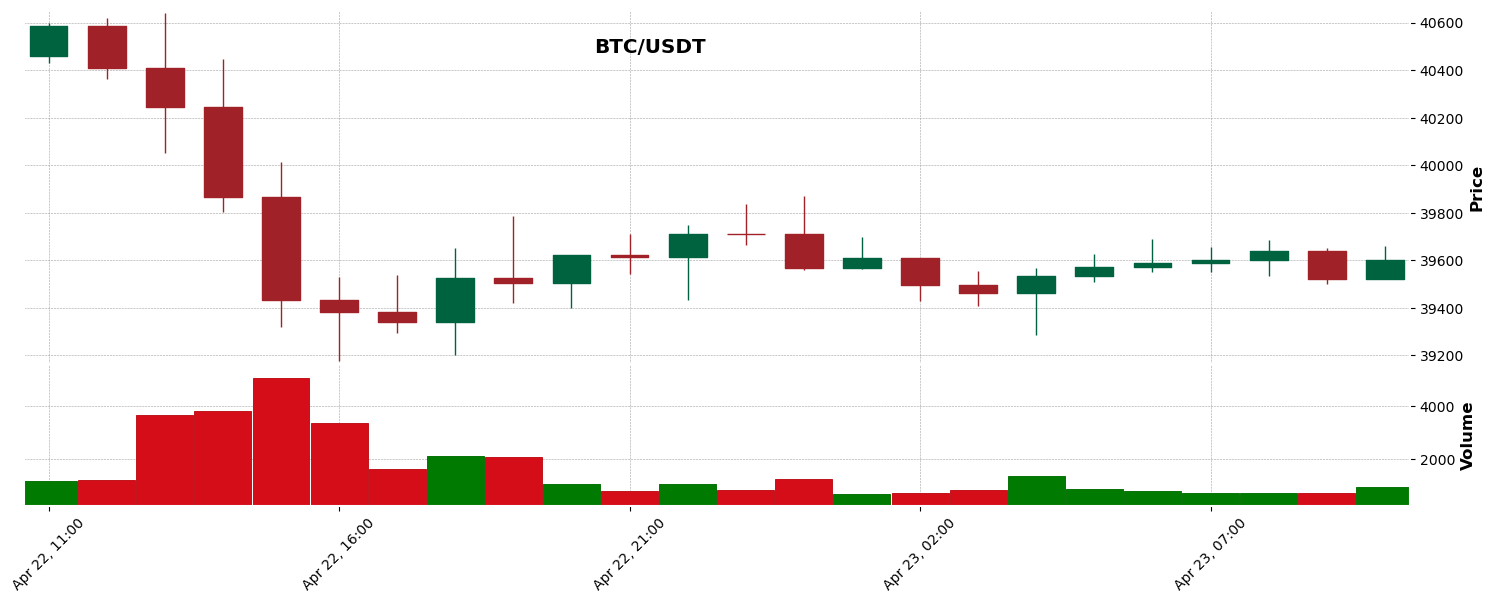

Initial Investment: 550.00 USDT
Final Value: 509.75 USDT
Profit: -40.25 USDT
Return on Investment (ROI): -7.32%


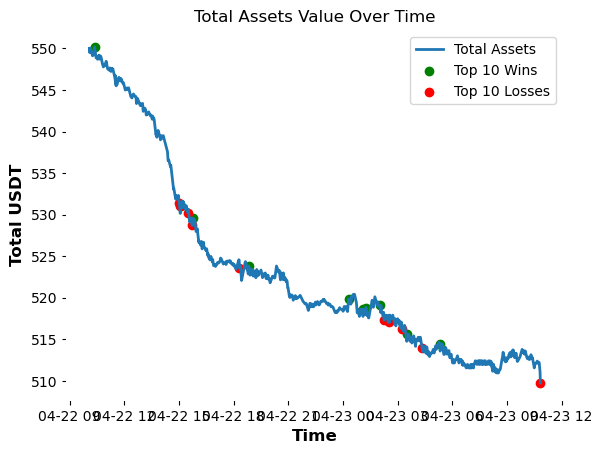

In [274]:
MAX_TRADE_PER_SLOTE=100
STOP_LOSS=2.5
TAKE_PROFIT=0.3
PRECISION=0.0
d1=pd.Timestamp("2022-04-22 10:05:00")
d2=pd.Timestamp("2022-04-23 10:50:00")
plot_ohlcv(df_list1h["BTC/USDT"],"BTC/USDT", start_date=d1, end_date=d2)
PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=d1, end_period=d2)
back_test_metrics( PORTFOLIO)
